In [69]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
df = pd.read_csv('./data/nbaallelo.csv')

# shuffle dataframe
df = df.sample(frac=1).reset_index(drop = True)

# drop duplicate game ids
df.drop_duplicates(subset = 'game_id', keep = 'first', inplace = True)

df.drop(['_iscopy', 'team_id', 'opp_id' , 'notes', 'elo_n', 'opp_elo_n'], axis = 1, inplace = True)
df.game_location.replace({'H': 1, 'A': 0, 'N': 0}, inplace = True)

df['elo_diff'] = df.elo_i - df.opp_elo_i
df.head()

,gameorder,game_id,lg_id,year_id,date_game,seasongame,is_playoffs,fran_id,pts,elo_i,win_equiv,opp_fran,opp_pts,opp_elo_i,game_location,game_result,forecast,elo_diff
0,60447,201304210IND,NBA,2013,4/21/2013,83,1,Hawks,90,1481.6061,37.964031,Pacers,107,1570.3324,0,L,0.252298,-88.7263
1,16280,197501230CLE,NBA,1975,1/23/1975,44,0,Knicks,100,1458.5112,40.959564,Cavaliers,89,1461.1407,0,W,0.356455,-2.6295
2,36355,199402200MIL,NBA,1994,2/20/1994,50,0,Magic,109,1586.1309,50.679184,Bucks,104,1367.4728,0,W,0.664419,218.6581
3,18059,197610300PHI,NBA,1977,10/30/1976,5,0,Sixers,104,1524.8036,44.883251,Nets,80,1566.4891,1,W,0.583142,-41.6855
4,10394,197002130SEA,NBA,1970,2/13/1970,63,0,Thunder,141,1419.5286,37.441196,Wizards,138,1520.1437,1,W,0.499115,-100.6151


In [3]:
print(df.shape)
print(df.info())

(63157, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 63157 entries, 0 to 126085
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gameorder      63157 non-null  int64  
 1   game_id        63157 non-null  object 
 2   lg_id          63157 non-null  object 
 3   year_id        63157 non-null  int64  
 4   date_game      63157 non-null  object 
 5   seasongame     63157 non-null  int64  
 6   is_playoffs    63157 non-null  int64  
 7   fran_id        63157 non-null  object 
 8   pts            63157 non-null  int64  
 9   elo_i          63157 non-null  float64
 10  win_equiv      63157 non-null  float64
 11  opp_fran       63157 non-null  object 
 12  opp_pts        63157 non-null  int64  
 13  opp_elo_i      63157 non-null  float64
 14  game_location  63157 non-null  int64  
 15  game_result    63157 non-null  object 
 16  forecast       63157 non-null  float64
 17  elo_diff       63157 non-null  float6

In [4]:
group = df.groupby('game_result').aggregate({'elo_i': np.average, 'opp_elo_i': np.average, 
                                             'game_location': np.average, 'game_id': 'count',
                                             'elo_diff': np.average}).rename(columns = {'game_id': 'count'})
group

,elo_i,opp_elo_i,game_location,count,elo_diff
game_result,,,,,
L,1469.244411,1521.774867,0.378587,31504,-52.530456
W,1521.078762,1468.848758,0.623574,31653,52.230004


### Perm Test

In [5]:
def perm_fun(df, col, len_a):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

### Elo Diffs

In [6]:
actual_diff = group.loc['W'].elo_diff
diffs = [perm_fun(df, 'elo_i', group.loc['W', 'count']) for _ in range(1000)]

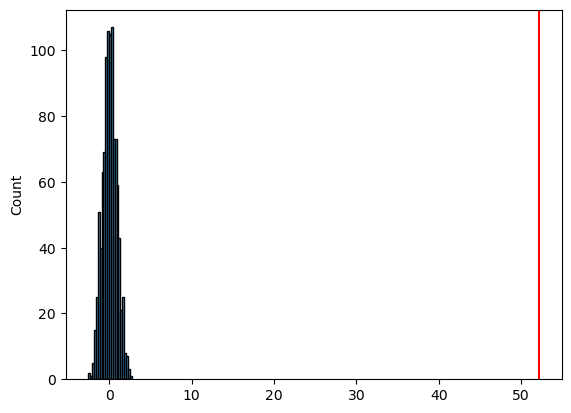

In [7]:
sns.histplot(diffs)
plt.axvline(actual_diff, color = 'red')
plt.show()

### Home Diffs

In [8]:
actual_diff = group.loc['W', 'game_location'] - group.loc['L', 'game_location']
diffs = [perm_fun(df, 'game_location', group.loc['W', 'count']) for _ in range(1000)]

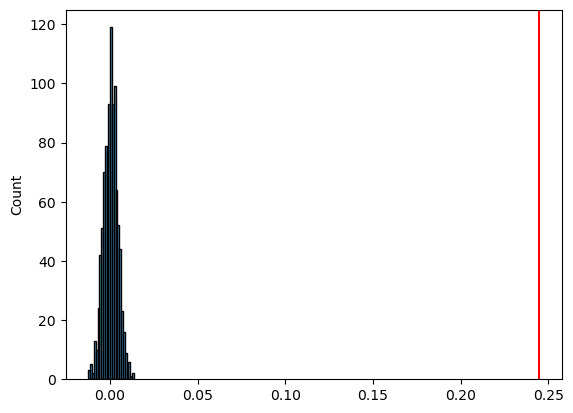

In [9]:
sns.histplot(diffs)
plt.axvline(actual_diff, color = 'red')
plt.show()

<AxesSubplot:>

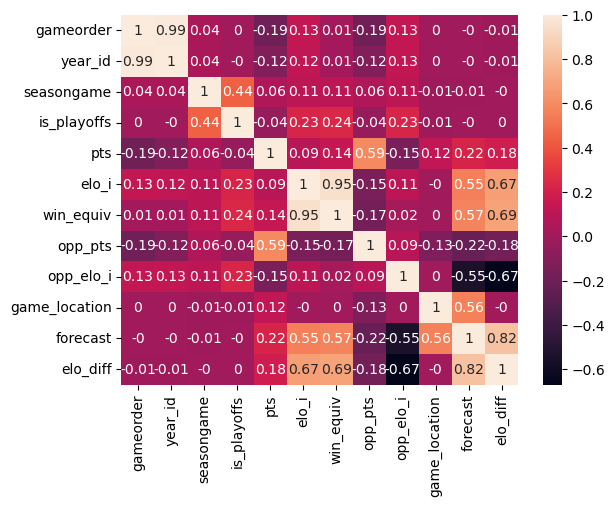

In [10]:
sns.heatmap(df.corr().round(2), annot = True)

## Modeling

#### Normalize Features

In [11]:
model_df = df[['elo_diff', 'game_location', 'game_result']].copy()

mu = model_df.elo_diff.mean()
std = model_df.elo_diff.std()


model_df.elo_diff = (model_df.elo_diff - mu) / std
model_df.game_result.replace({'W': 1, 'L': 0}, inplace = True)
model_df

,elo_diff,game_location,game_result
0,-0.591351,0,0
1,-0.017353,0,1
2,1.457947,0,1
3,-0.277735,1,1
4,-0.670612,1,1
...,...,...,...
125230,-0.048659,0,0
125260,1.447626,0,1
125603,-0.502326,1,1
125918,-0.834965,1,0


In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [32]:
def compute_cost(a, y):
    """
    input paramters:
        w, b: parameters for model
        x: feature values
        y: target values
        
    output:
        total cost for given parameters
    """

    m = y.shape[0]
    
    log_loss = np.sum(-y * np.log(a) - (1 - y) * np.log(1 - a))
    total_cost = log_loss / m
    
    return total_cost

In [14]:
def forward_prop(w, b, x):
    # send forward predictor values
    a = sigmoid(np.dot(x, w) + b)
    
    return a

In [15]:
def backward_prop(w, b, x, y):
    """
    input parameters:
        w, b: parameters for model
        x: train values
        y: train target values
        
    return:
        partial derivatives for w, b
    """
    
    dj_dw = np.zeros(len(w))
    dj_db = 0
    
    m = x.shape[0]
    
    for i in range(m):
        f_wb_i = sigmoid(np.dot(x[i], w) + b)
        
        for j in range(len(w)):
            dj_dw[j] += (f_wb_i - y[i]) * x[i, j]
        
        dj_db += f_wb_i - y[i]
        
    dj_dw = dj_dw / m
    dj_db = dj_db / m
    
    return dj_dw, dj_db
        

In [16]:
def update_parameters(w, b, x, y, alpha):
    """
    input parameters:
        w, b: parameters for model
        x: feature values
        y: target values
        alpha: learning rate
        
    output:
        updates parameters w, b
    """
    
    dj_dw, dj_db = backward_prop(w, b, x, y)
    
    w = w - alpha * dj_dw
    b = b - alpha * dj_db
    
    return w, b

In [35]:
def nn_model(w, b, x, y, alpha, iterations):
    """
    input parameters:
        w, b: initial parameters for model
        x, y: feature and target values
        alpha: learning rate
        iterations: numbers of times to update variables
    
    returns:
        updated parameters of the model
    """
    w_in = w.copy()
    
    for i in range(iterations):
        a = forward_prop(w, b, x)
        
        cost = compute_cost(a, y)
        
        dj_dw, dj_db = backward_prop(w, b, x, y)
        
        w, b = update_parameters(w, b, x, y, alpha)
        
        if i % 100 == 0:
            print(f"total cost at {i} iterations:", cost)
            
    return w, b
        

In [36]:
# initialize parameters

w = np.array([5, 3])
b = 5

X = np.array(model_df[['elo_diff', 'game_location']])
y = np.array(model_df.game_result)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7)

alpha = .1
iterations = 1000

w_out, b_out = nn_model(w, b, X_train, y_train, alpha, iterations)

total cost at 0 iterations: 2.5116733563461677
total cost at 100 iterations: 1.3596368000704122
total cost at 200 iterations: 0.8352012588483029
total cost at 300 iterations: 0.6315276674045409
total cost at 400 iterations: 0.5939482791233637
total cost at 500 iterations: 0.5912868196249182
total cost at 600 iterations: 0.5911643256583465
total cost at 700 iterations: 0.5911575226232142
total cost at 800 iterations: 0.5911563323985514
total cost at 900 iterations: 0.5911558460915117


In [37]:
def pred(w, b, x):
    pred = sigmoid(np.dot(x, w) + b)
    return pred

In [68]:
model_df["WinProb"] = model_df.apply(lambda x: pred(w_out, b_out, np.array(x[['elo_diff', 'game_location']])), axis = 1)
model_df["Prediction"] = (model_df.WinProb >= .5).replace({True: 1, False: 0})

model_df

,elo_diff,game_location,game_result,WinProb,Prediction
0,-0.591351,0,0,0.250391,0
1,-0.017353,0,1,0.354414,0
2,1.457947,0,1,0.663133,1
3,-0.277735,1,1,0.585675,1
4,-0.670612,1,1,0.501513,1
...,...,...,...,...,...
125230,-0.048659,0,0,0.348239,0
125260,1.447626,0,1,0.661134,1
125603,-0.502326,1,1,0.537856,1
125918,-0.834965,1,0,0.466001,0


In [72]:
print("accuracy score:", accuracy_score(model_df.game_result, model_df.Prediction))
print("precision score:", precision_score(model_df.game_result, model_df.Prediction))
print("recall score:", recall_score(model_df.game_result, model_df.Prediction))

accuracy score: 0.6810646484158526
precision score: 0.6822933164396578
recall score: 0.6805042176097053
